# PyTorch Image-Classification

Autor: Gabriel Dornelles Monteiro, outubro de 2022. Notebook nº8.

Chegando ao fim dos módulos, neste notebook iremos treinar uma rede convolucional moderna e leve (EfficientNet-B0) em imagens 224x224 com 15 diferentes raças de gatos. Após o treinamento iremos visualizar com o Grad-Cam o que é que o modelo está levando em consideração na imagem para escolher a sua resposta.

O dataset que utilizaremos pode ser baixado aqui:
https://www.kaggle.com/datasets/shawngano/gano-cat-breed-image-collection

## Split do dataset

In [1]:
#!pip3 install split-folders
import splitfolders
splitfolders.ratio('/home/gabriel/Documents/Gabriel/Modern-Computer-Vision/Gano-Cat-Breeds-V1_1', output="cats_dataset_splitted", seed=1337, ratio=(0.8, 0.1,0.1)) 

Copying files: 5625 files [00:00, 8847.44 files/s]


## Criação dos datasets e dataloaders

In [2]:
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms


train_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=(170,170)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = 'cats_dataset_splitted'

train_dataset = datasets.ImageFolder(os.path.join(data_dir + "/train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir + "/val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir + "/test"), transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print(num_classes)
print(class_names)

15
['Abyssinian', 'American Bobtail', 'American Shorthair', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx', 'Tuxedo']


## Definição do modelo, otimizador e loss function

In [14]:
from torchvision import models
import torch.nn as nn
from torch import optim

device = torch.device('cuda')

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights)
model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes, bias=True)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

## Definição das funções de treino, validação e teste

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import copy
import numpy as np


def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            output_prob = model(inputs)
            _, predicted_labels = torch.max(output_prob, 1)

            n += labels.size(0) # add batch_size num of samples being iterated
            correct_pred += (predicted_labels == labels).sum() # sum array of bools (1's are correct predictions)

    return correct_pred.float() / n

def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        running_loss += loss.item() * inputs.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def val(val_loader, model, criterion, device):
  
    model.eval()
    running_loss = 0
    
    for inputs, labels in val_loader:
    
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass and record loss
        with torch.no_grad():
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(val_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, test_dataloader, epoches, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_acc = 0.0
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model and validate
    for epoch in range(epoches):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = val(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        # accuracies
        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            test_acc = get_accuracy(model, test_dataloader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                    f'Epoch: {epoch}\t'
                    f'Train loss: {train_loss:.4f}\t'
                    f'Valid loss: {valid_loss:.4f}\t'
                    f'Train accuracy: {100 * train_acc:.2f}\t'
                    f'Val accuracy: {100 * valid_acc:.2f}\t'
                    f'Test accuracy: {100 * test_acc:.2f}')

        # create a copy of our model when it test its best
        if test_acc >= best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    plot_losses(train_losses, valid_losses)
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

## Treinamento

23:26:45 --- Epoch: 0	Train loss: 1.2226	Valid loss: 0.6971	Train accuracy: 83.96	Val accuracy: 76.76	Test accuracy: 76.01
23:27:07 --- Epoch: 1	Train loss: 0.6415	Valid loss: 0.6134	Train accuracy: 90.71	Val accuracy: 79.64	Test accuracy: 77.93
23:27:29 --- Epoch: 2	Train loss: 0.4533	Valid loss: 0.6181	Train accuracy: 95.09	Val accuracy: 78.74	Test accuracy: 82.14
23:27:51 --- Epoch: 3	Train loss: 0.3314	Valid loss: 0.6807	Train accuracy: 97.00	Val accuracy: 79.10	Test accuracy: 81.26
23:28:13 --- Epoch: 4	Train loss: 0.2492	Valid loss: 0.7129	Train accuracy: 97.87	Val accuracy: 76.04	Test accuracy: 79.86
23:28:35 --- Epoch: 5	Train loss: 0.2089	Valid loss: 0.7169	Train accuracy: 99.20	Val accuracy: 78.92	Test accuracy: 83.19
23:28:58 --- Epoch: 6	Train loss: 0.1522	Valid loss: 0.7456	Train accuracy: 99.11	Val accuracy: 78.74	Test accuracy: 80.74
23:29:20 --- Epoch: 7	Train loss: 0.1612	Valid loss: 0.7025	Train accuracy: 98.78	Val accuracy: 78.92	Test accuracy: 79.68
23:29:42 --- Epo

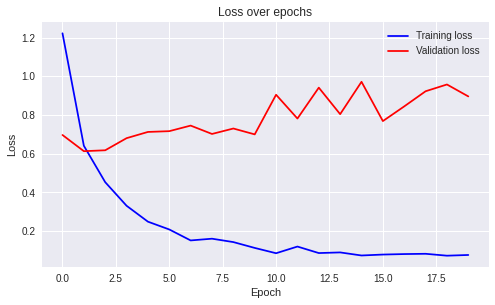

In [15]:
model = training_loop(model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    train_loader=train_dataloader, 
    valid_loader=val_dataloader, 
    test_dataloader=test_dataloader,
    epoches=20, 
    device=device, 
    print_every=1
)

## Vamos visualizar o que o modelo vê na imagem para definir a sua escolha!

In [16]:
from torch.nn import functional as F
# @Author: Kazuto Nakashima  => https://github.com/kazuto1011/grad-cam-pytorch
class _BaseWrapper(object):
    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:]
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        def save_fmaps(key):
            def forward_hook(module, input, output):
                self.fmap_pool[key] = output.detach()

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient

/home/gabriel/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Doing backward for class 'Siamese'
Doing backward for class 'Maine Coon'


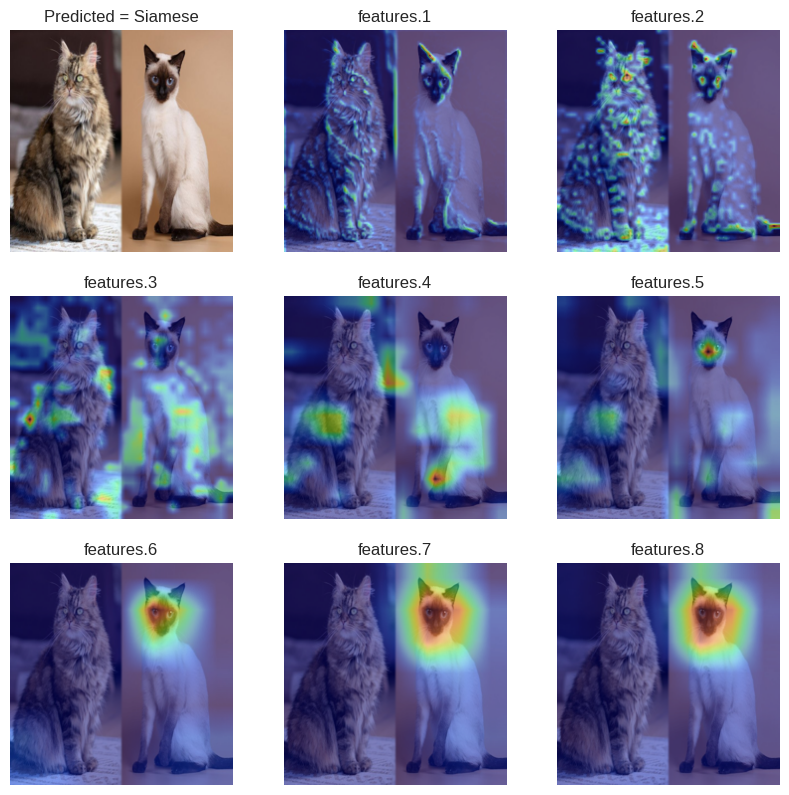

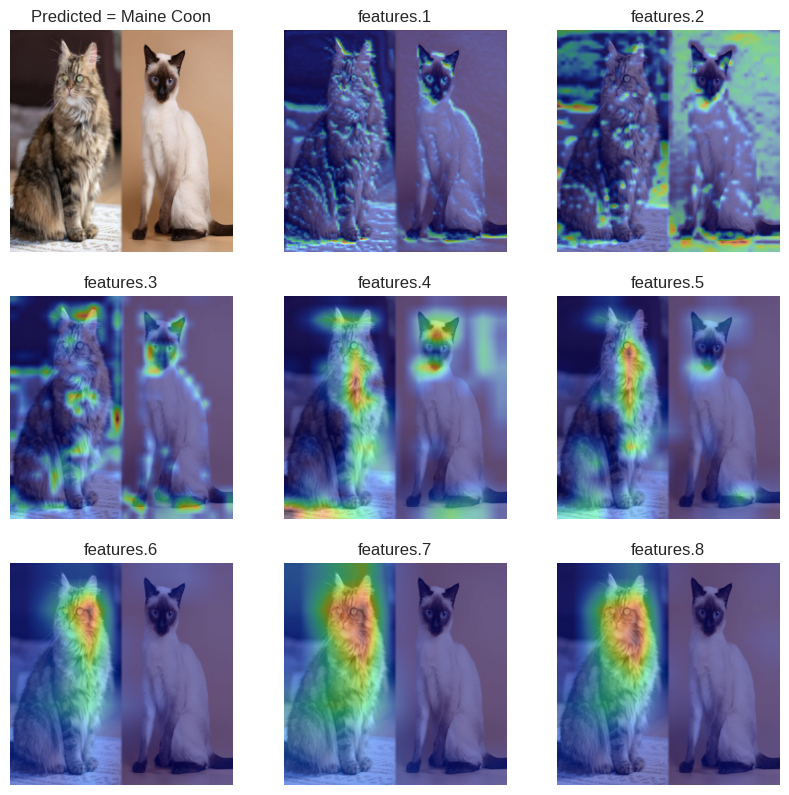

In [136]:
import cv2
from PIL import Image

for id_ in [0,2]:
    # in this example, 0 is the predicted class, siamese, second choice was birman, and third choice was Maine coon. We have a Maine Coon and a siamese cat in the image
    image = Image.open("cats_dataset_splitted/test/persian_and_siamese.jpg").resize((224,224))
    plot_image = np.array(image)
    image = transform(image)
    image = image[None,...]
    image = image.float().cuda()

    model_answer = model(image)
    _, predictions = model_answer.max(1)
    predicted = class_names[predictions]
    bp = BackPropagation(model=model)
    probs, ids = bp.forward(image)  # sorted

    gcam = GradCAM(model=model)
    _ = gcam.forward(image)

    print(f"Doing backward for class '{class_names[int(ids[:, [id_]])]}'")
    gcam.backward(ids=ids[:, [id_]])
    plt.figure(figsize=(10, 10), dpi=100, facecolor="white")
    cnt=1
    plt.subplot(3,3, cnt)
    plt.imshow(plot_image)
    plt.title(f"Predicted = {class_names[int(ids[:, [id_]])]}")

    for layer in ["features.1","features.2","features.3","features.4","features.5","features.6","features.7","features.8"]:
        regions = gcam.generate(target_layer=f"{layer}") # convs are 0 4 and 8
        regions = regions.detach().cpu().numpy()[0][0]
        cnt+=1
        regions = (regions * 255)
        regions = regions.astype(np.uint8)
        regions = np.invert(regions) # https://stackoverflow.com/questions/58977133/how-to-restore-image-color-after-converting-it-from-a-float32-type-to-uint8-type, I found that this simple conversion leads to inversion so we're inverting it back
        heatmap = cv2.applyColorMap(regions, cv2.COLORMAP_TURBO)
        mapped = cv2.addWeighted(heatmap, 0.5, (plot_image).astype(np.uint8), 0.5, 0)
        plt.grid(False)
        plt.axis(False)
        plt.subplot(3,3, cnt)
        plt.grid(False)
        plt.axis(False)
        plt.title(layer)
        plt.imshow(mapped)

## Salve o modelo

In [137]:
torch.save(model.state_dict(), "cat_classifier.pth")

## Inferência

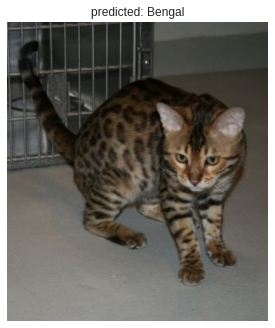

In [147]:
from PIL import Image

# Carregando o modelo
device = torch.device('cuda')
model = models.efficientnet_b0()
model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes, bias=True)
model.load_state_dict(torch.load("cat_classifier.pth"))
model.eval()
model.to(device)

# Mantemos o transform utilizado para validação
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image = Image.open("cats_dataset_splitted/test/Bengal/Bengal-20822547_8622.jpg")
plt.imshow(np.array(image))
plt.grid(False)
plt.axis(False)
image = transform(image)
image = image[None,...]
image = image.float().cuda()
with torch.no_grad():
    output = model(image)
_, predicted = torch.max(output, 1)
answer = class_names[predicted]
plt.title(f"predicted: {answer}")
plt.show()